# **Import Libraries**

In [ ]:
import torch
torch.cuda.is_available()

False

In [ ]:
# Install official library containing YOLO models
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.3 MB/s eta 0:00:00


In [ ]:
import os
import cv2
import time
import yaml
import shutil
import random
import zipfile
import collections
import numpy as np
import collections
import pandas as pd
import seaborn as sns
from pathlib import Path
from sklearn.svm import SVC
from ultralytics import YOLO
import matplotlib.pyplot as plt
from IPython.display import FileLink
from sklearn.pipeline import Pipeline
from scipy.stats import uniform, randint
from IPython.display import display, HTML
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Load and Visualize the Data with its Labels**

In [ ]:
# Dataset path
dataset = '/content/drive/MyDrive/door_case/dataset/full'
images_path = os.path.join(dataset, "images")
labels_path = os.path.join(dataset, "labels")

In [ ]:
classes = {
    0: "close_door",
    1: "open_door",
    2: "semi_door"
}

In [ ]:
# Initialize a counter for each class with 0
counts = {name: 0 for name in classes.values()}
labels_path = os.path.join(dataset, "labels")

# Loop over all label
for f in os.listdir(labels_path):
  if f.endswith(".txt"):
    with open(os.path.join(labels_path, f), "r") as file:
      line = file.readline().strip()
      if line:
        cls_id = int(line.split()[0])
        class_name = classes[cls_id]
        counts[class_name] += 1

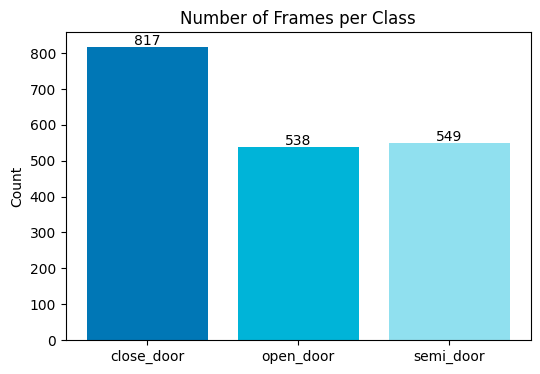

In [ ]:
# Plot
plt.figure(figsize=(6,4))
plt.bar(counts.keys(), counts.values(), color=['#0077b6','#00b4d8','#90e0ef'])
plt.title("Number of Frames per Class")
plt.ylabel("Count")

# Add numeric value on top of each bar
for i, (cls, cnt) in enumerate(counts.items()):
    plt.text(i, cnt + 5, str(cnt), ha='center', fontsize=10)

plt.show()

In [ ]:
# Function to draw YOLO bounding boxes
def draw_bbox(img, label_path):
    h, w = img.shape[:2] # Get image height & width

    # Read label file line by line
    with open(label_path, "r") as f:
        for line in f:
            # YOLO format: class x_center y_center width height
            c, xc, yc, bw, bh = map(float, line.split())

            # Convert coordinates to pixel
            x1 = int((xc - bw/2) * w)
            y1 = int((yc - bh/2) * h)
            x2 = int((xc + bw/2) * w)
            y2 = int((yc + bh/2) * h)

            # Draw rectangl on the image
            if c == 0:
              cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
            elif c == 1:
              cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
            else:
              cv2.rectangle(img, (x1, y1), (x2, y2), (0, 0, 255), 2)
    return img

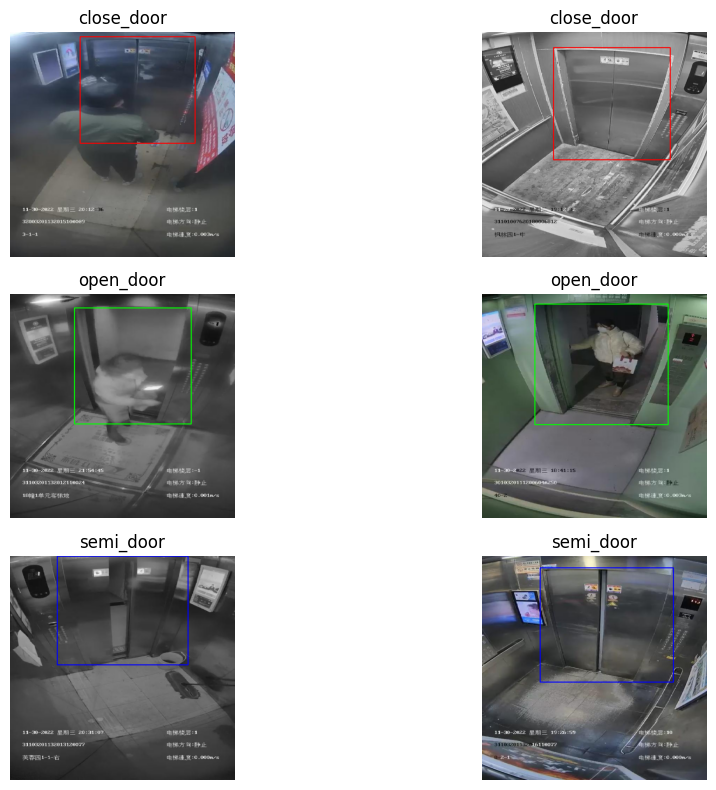

In [ ]:
# Display 2 samples per class

plt.figure(figsize=(12, 8))
idx = 1 # Subplot index

for cls_id, cls_name in classes.items():
    # Get all label files
    class_labels = [
        f for f in os.listdir(labels_path)
        if f.endswith(".txt") and int(open(os.path.join(labels_path, f)).read().split()[0]) == cls_id
    ]

    # Take 2 random samples from this class
    sample_labels = random.sample(class_labels, 2)

    for lb in sample_labels:
        # Matching image name with label
        img_name = lb.replace(".txt", ".jpg")

        img_path = os.path.join(images_path, img_name)
        label_path = os.path.join(labels_path, lb)

        # Load and convert image to RGB
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Draw the bounding box
        img = draw_bbox(img, label_path)

        # Show image in a subplot
        plt.subplot(3, 2, idx)
        plt.imshow(img)
        plt.title(cls_name)
        plt.axis("off")
        idx += 1

plt.tight_layout()
plt.show()

# **Split the dataset for YOLO**

In [ ]:
output_path = "/content/drive/MyDrive/door_case/splitted_dataset"
if os.path.exists(output_path):
    shutil.rmtree(output_path)

# Create empty folders for the split each with images and labels
for split in ["train", "val", "test"]:
    os.makedirs(f"{output_path}/{split}/images", exist_ok=True)
    os.makedirs(f"{output_path}/{split}/labels", exist_ok=True)

In [ ]:
# Function to extract the video name
def get_video_name(filename):
    return filename.split("-")[0].lower()

In [ ]:
# Dictionary for the video with list of its frames
video_dict = {}
all_files = os.listdir(images_path)

for f in all_files:
    if f.endswith(".jpg"):
        vid = get_video_name(f)
        video_dict.setdefault(vid, []).append(f)

In [ ]:
# Shuffle the list of videos to make random split
video_list = list(video_dict.keys())
random.shuffle(video_list)

In [ ]:
# Compue split sizes (70% train, 20% val, 10% test)
total = len(video_list)
train_end = int(total * 0.7)
val_end   = int(total * 0.9)

train_vids = video_list[:train_end]
val_vids   = video_list[train_end:val_end]
test_vids  = video_list[val_end:]

#Store in dictionary
sets = {
    "train": train_vids,
    "val": val_vids,
    "test": test_vids
}

In [ ]:
# Copy the images and labels to their new split folders
for split, vids in sets.items():
    print(f"{split}: {len(vids)} videos")

    for vid in vids: # Loop on video
        for img in video_dict[vid]: # Loop on all frames of that video
            img_src = os.path.join(images_path, img)
            lbl_src = os.path.join(labels_path, img.replace(".jpg", ".txt"))

            img_dst = os.path.join(output_path, split, "images", img)
            lbl_dst = os.path.join(output_path, split, "labels", img.replace(".jpg", ".txt"))

            shutil.copy(img_src, img_dst) # Copy image
            shutil.copy(lbl_src, lbl_dst) # Copy its label

print("\nDone\nvideo-based splitting created.")

train: 224 videos
val: 64 videos
test: 33 videos

Done
video-based splitting created.


In [ ]:
splits = {
    "train": "/content/drive/MyDrive/door_case/splitted_dataset/train/labels",
    "val": "/content/drive/MyDrive/door_case/splitted_dataset/val/labels",
    "test": "/content/drive/MyDrive/door_case/splitted_dataset/test/labels"
}

all_results = {}

# Loop through each split and count how many samples belong to each class
for split, label_folder in splits.items():
    class_counts = {0: 0, 1: 0, 2: 0} # Class ID : Count start with 0

    # Loop over all label files
    for f in os.listdir(label_folder):
      if f.endswith(".txt"):
        path = os.path.join(label_folder, f)

        with open(path, "r") as file:
          lines = file.readlines()

          # Extract the class ID from the first line of the label file
          cls_id = int(lines[0].split()[0])
          class_counts[cls_id] += 1

    all_results[split] = class_counts

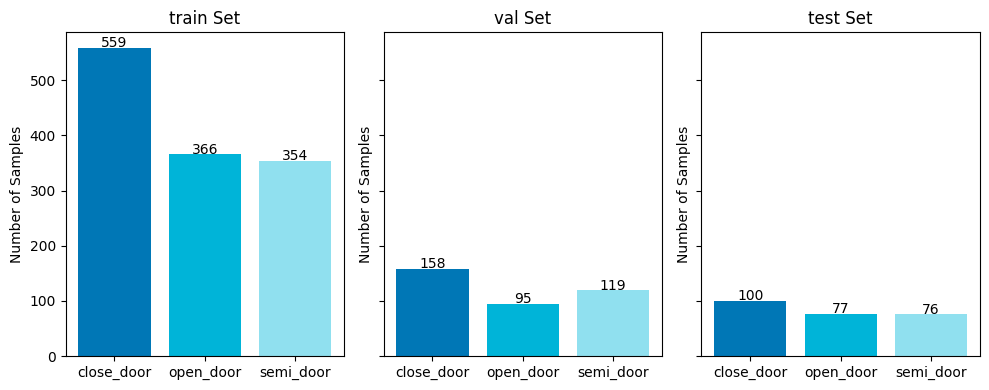

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharey=True)
for idx, (split, counts) in enumerate(all_results.items()):
    ax = axes[idx]

    # Craete bar chart for the split
    ax.bar(
        ["close_door", "open_door", "semi_door"],
        [counts[0], counts[1], counts[2]],
        color=['#0077b6','#00b4d8','#90e0ef']
    )

    ax.set_title(f"{split} Set")
    ax.set_ylabel("Number of Samples")

    # Write the total above the bars
    for i, v in enumerate([counts[0], counts[1], counts[2]]):
        ax.text(i, v + 1, str(v), ha='center', fontsize=10)

plt.tight_layout()
plt.show()

# **YOLO Configuration & Fine-Tuning**

In [ ]:
# Create the YAML file
yolo_yaml = "/content/drive/MyDrive/door_case/data.yaml"

# Create the YAML content
yaml_content = """
train: /content/drive/MyDrive/door_case/splitted_dataset/train/images
val: /content/drive/MyDrive/door_case/splitted_dataset/val/images
test: /content/drive/MyDrive/door_case/splitted_dataset/test/images

nc: 3
names: ['close_door', 'open_door', 'semi_door']
"""

with open(yolo_yaml,'w') as f:
    f.write(yaml_content.strip())

In [ ]:
model = YOLO('yolo11n.pt')

In [ ]:
torch.cuda.is_available()

True

In [ ]:
results = model.train(
    data = yolo_yaml,
    epochs = 70,
    imgsz = 640,
    batch = 16,
    optimizer = 'SGD',
    name = '/content/drive/MyDrive/door_case/yolov11_custom_train',
    augment = True
)

Ultralytics 8.3.228 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/door_case/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=70, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov11_custom_train, nbs=64, nms=False, opset=None, optimize=False, optimizer=SGD, overlap_mask=True, patience=100, perspect

# **YOLO Testing & Evaluation**

In [ ]:
model_path = '/content/drive/MyDrive/door_case/yolov11_custom_train/weights/best.pt'
yolo_yaml = '/content/drive/MyDrive/door_case/data.yaml'
model = YOLO(model_path)
metrics =  model.val(data = yolo_yaml, imgsz=640, split ="test")

Ultralytics 8.3.228 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,737 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 3.0±5.3 ms, read: 0.2±0.2 MB/s, size: 47.6 KB)
val: Scanning /content/drive/MyDrive/door_case/splitted_dataset/test/labels... 253 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 253/253 2.2it/s 1:56
val: New cache created: /content/drive/MyDrive/door_case/splitted_dataset/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 16/16 2.8it/s 5.8s
                   all        253        253      0.958      0.963       0.99      0.718
            close_door        100        100      0.988       0.97      0.994      0.743
             open_door         77         77      0.938      0.989      0.994      0.701
             semi_door         76         76      0.946      0.931      0.982      0.709
Speed: 4.0ms preprocess,

In [ ]:
precision = round(float(metrics.box.mp), 3)
recall = round(float(metrics.box.mr), 3)
map50 = round(float(metrics.box.map50), 3)
map5095 = round(float(metrics.box.map), 3)

print("\nYOLO Evaluation Results")
print(f" Precision   : {precision}")
print(f" Recall      : {recall}")
print(f" mAP@50      : {map50}")
print(f" mAP@50-95   : {map5095}")



YOLO Evaluation Results
 Precision   : 0.958
 Recall      : 0.963
 mAP@50      : 0.99
 mAP@50-95   : 0.718


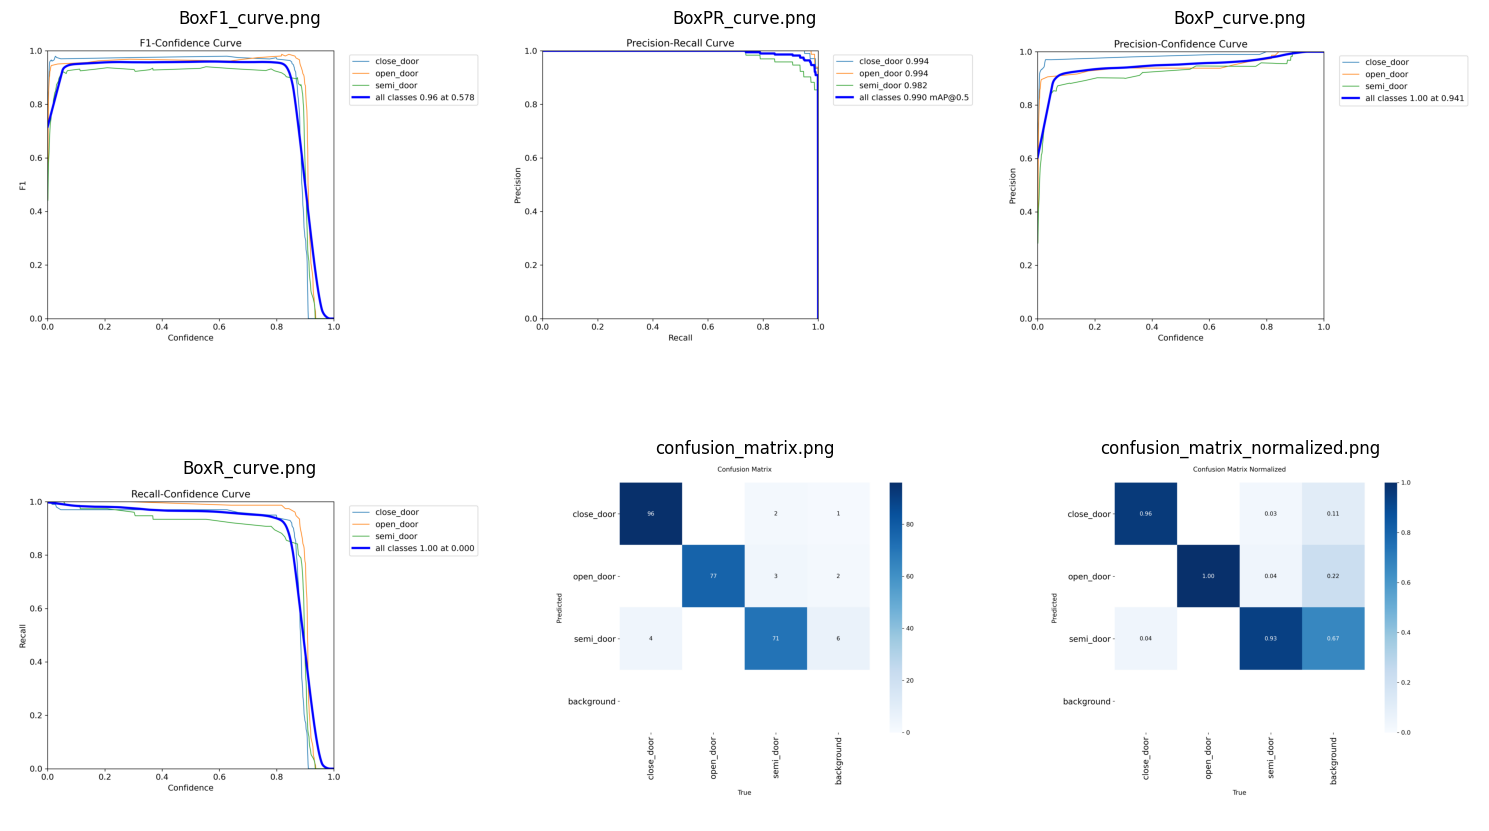

In [ ]:
# Path to YOLO testing result images
path = "/content/drive/MyDrive/door_case/runs/detect/val"

# Get all png and jpg images
imgs = sorted([f for f in os.listdir(path) if f.endswith((".png",".jpg"))])

#Select the first 6 (exclude val_batch images)
main_imgs = [i for i in imgs if not i.startswith("val_batch")][:6]

plt.figure(figsize=(15,10))
for i, name in enumerate(main_imgs):
    img = cv2.cvtColor(cv2.imread(f"{path}/{name}"), cv2.COLOR_BGR2RGB)
    plt.subplot(2,3,i+1); plt.imshow(img); plt.title(name); plt.axis("off")

plt.tight_layout(); plt.show()

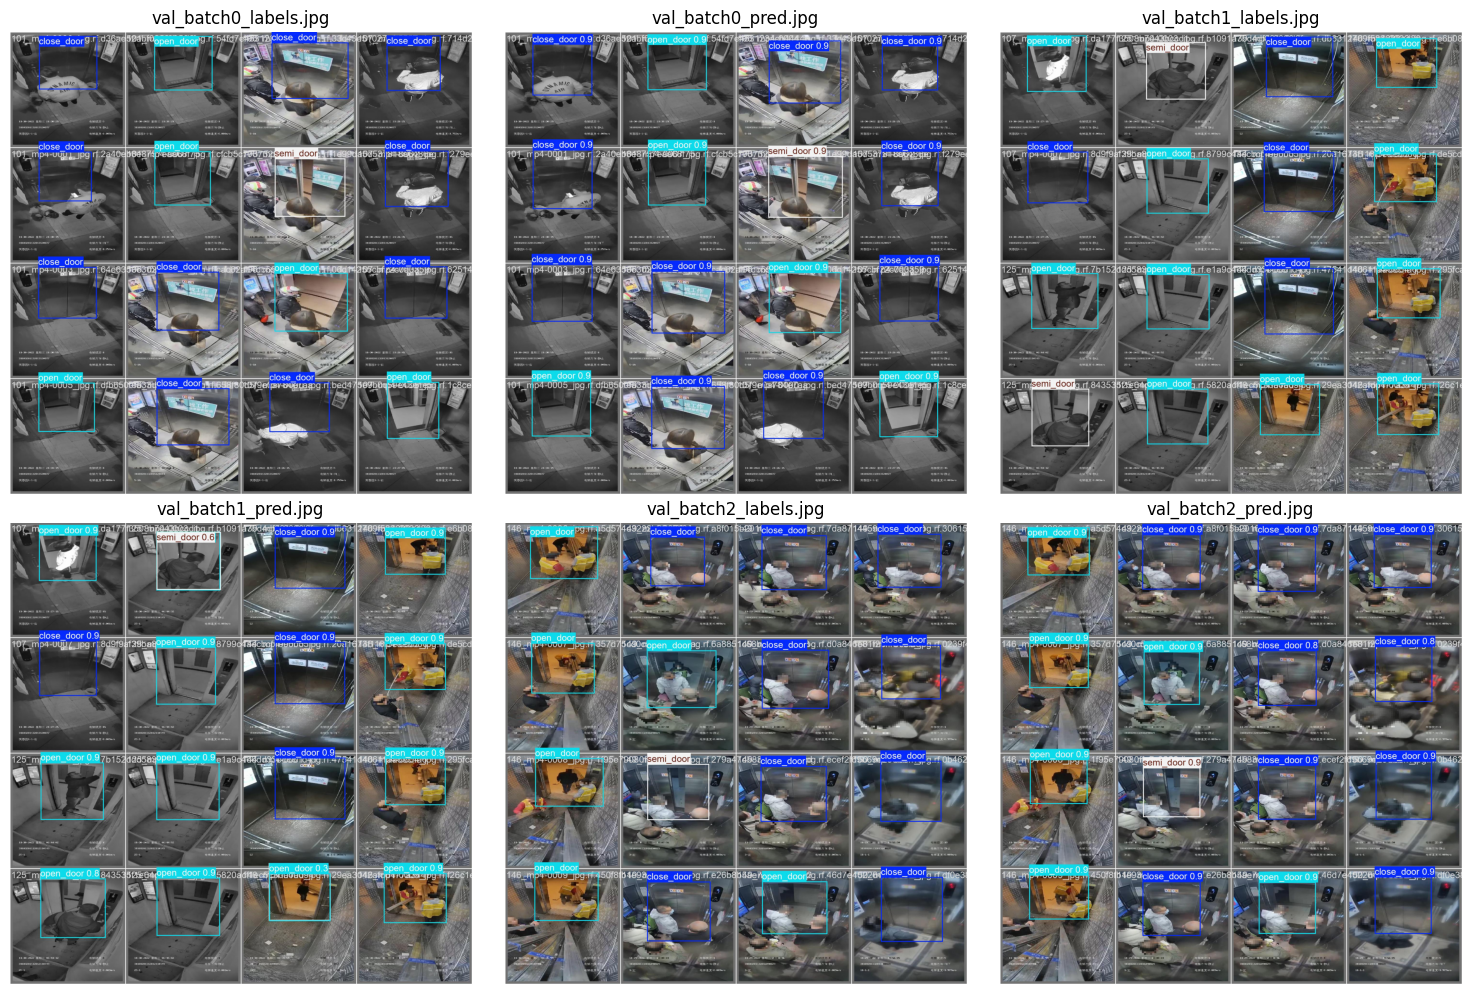

In [ ]:
# Get all val_batch images
val_imgs = sorted([i for i in imgs if i.startswith("val_batch")])

plt.figure(figsize=(15,10))
for i, name in enumerate(val_imgs):
    img = cv2.cvtColor(cv2.imread(f"{path}/{name}"), cv2.COLOR_BGR2RGB)
    plt.subplot(2,3,i+1); plt.imshow(img); plt.title(name); plt.axis("off")

plt.tight_layout(); plt.show()

In [ ]:
'''
zip_path = "/workspace/processed_dataset.zip"
output_folder = "/workspace/OUTPUT_1"

os.makedirs(output_folder, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(output_folder)

print("Unzip complete!")

zip_path = "/content/normal-door.zip"
output_folder = "/content/normal-door"
os.makedirs(output_folder, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(output_folder)

print("Unzip complete!")
'''

'\nzip_path = "/workspace/processed_dataset.zip"\noutput_folder = "/workspace/OUTPUT_1"\n\nos.makedirs(output_folder, exist_ok=True)\n\nwith zipfile.ZipFile(zip_path, \'r\') as zip_ref:\n    zip_ref.extractall(output_folder)\n\nprint("Unzip complete!")\n\nzip_path = "/content/normal-door.zip"\noutput_folder = "/content/normal-door"\nos.makedirs(output_folder, exist_ok=True)\n\nwith zipfile.ZipFile(zip_path, \'r\') as zip_ref:\n    zip_ref.extractall(output_folder)\n\nprint("Unzip complete!")\n'

In [ ]:
# AUTO-DETECT the two folders
ROOT = Path("/content")

# Find the two class folders even if nested
class_dirs = [
    p for p in ROOT.rglob("*")
    if p.is_dir() and p.name in ["normal-door", "lag-door"]
]

if len(class_dirs) == 0:
    raise Exception(" Could not find normal-door or lag-door folders!")
else:
    print("Found class folders:")
    for d in class_dirs:
        print(" -", d)

# Where to save output
OUTPUT = ROOT / "processed_dataset"
train_dir = OUTPUT / "train"
test_dir = OUTPUT / "test"
train_dir.mkdir(parents=True, exist_ok=True)
test_dir.mkdir(parents=True, exist_ok=True)

TEST_RATIO = 0.2
VIDEO_EXT = [".mp4", ".avi", ".mov", ".mkv"]

def is_video(name):
    return any(name.lower().endswith(ext) for ext in VIDEO_EXT)

all_files = {}

# Collect videos
for folder in class_dirs:
    class_name = folder.name  # "normal-door" or "lag-door"
    all_files[class_name] = []

    for f in folder.iterdir():
        if is_video(f.name):
            newname = f"{class_name}_{f.name}"
            all_files[class_name].append((f, newname))

    print(f"\nClass '{class_name}' found {len(all_files[class_name])} videos.")

# Balanced split
for cls, files in all_files.items():
    if len(files) == 0:
        print(f" WARNING: No videos found in class {cls}")
        continue

    random.shuffle(files)
    test_count = int(len(files) * TEST_RATIO)

    test_subset = files[:test_count]
    train_subset = files[test_count:]

    for src, newname in test_subset:
        shutil.copy(src, test_dir / newname)

    for src, newname in train_subset:
        shutil.copy(src, train_dir / newname)

    print(f"\nClass '{cls}' split:")
    print(f"  total={len(files)}, train={len(train_subset)}, test={len(test_subset)}")

print("\n DONE! Files copied and balanced.")


Found class folders:
 - /content/normal-door
 - /content/lag-door
 - /content/normal-door/normal-door
 - /content/lag-door/lag-door
 - /content/normal-door/normal-door/normal-door

Class 'normal-door' found 0 videos.

Class 'lag-door' found 0 videos.

Class 'normal-door' found 0 videos.

Class 'lag-door' found 200 videos.

Class 'normal-door' found 147 videos.

Class 'normal-door' split:
  total=147, train=118, test=29

Class 'lag-door' split:
  total=200, train=160, test=40

✅ DONE! Files copied and balanced.


In [ ]:
shutil.make_archive("processed_dataset", "zip", "/content/processed_dataset")

'/content/processed_dataset.zip'

In [ ]:
zip_path = "/workspace/processed_dataset.zip"
output_folder = "/workspace/OUTPUT_1"

os.makedirs(output_folder, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(output_folder)

print("Unzip complete!")


Unzip complete!


## YOLO Detection + Optical Flow for Train Dataset


In [ ]:
# Load yolo trained model
model = YOLO("/workspace/best.pt")

In [ ]:
# Folder containing the original input videos to be analyzed for training
INPUT_FOLDER = "/workspace/OUTPUT_1/train"
# Path to the CSV file that will store the analysis results
REPORT_CSV = "/workspace/OUTPUT_1/door_analysis_report.csv"
# Directory where processed videos with annotations will be saved
OUTPUT_FOLDER = "/workspace/OUTPUT_1/output_videos"
os.makedirs(OUTPUT_FOLDER, exist_ok=True)
# Minimum time in seconds required between detected door state changes
STATE_CHANGE_EVERY_SECONDS = 5
# Threshold for considering significant motion/change between frames
MOTION_THRESHOLD = 0.3
# List of possible door states that the model can predict
CLASS_NAMES = ["close_door", "open_door", "semi_door"]
# BGR colors for drawing bounding boxes/text (Blue for closed, Green for open, Orange for semi-open)
COLORS = [(255,0,0), (0,255,0), (0,165,255)]

In [ ]:
def analyze_door_motion(states, motion, motion_threshold=0.3):
    # Create list to store transitions
    transitions = []
    # Initialize cycles counter
    cycles = 0
    # Flag for stuck-open behavior
    stuck_open = False
    # Flag for stuck-semi-open behavior
    stuck_semi = False
    # Flag for lagging or erratic behavior
    lagging = False
    # Loop through states to detect transitions
    for i in range(1, len(states)):
      # If a change occurs → this is a transition
        if states[i] != states[i-1]:
            transitions.append((states[i-1], states[i]))
    # Loop through transitions to count open-close cycles
    for a, b in transitions:
        # Closed → Open indicates a new cycle
        if a == 0 and b == 1:
            cycles += 1
    # Detect stuck-open (too many open frames + low motion)
    if states.count(1) > len(states) * 0.6 and np.mean(motion) < motion_threshold:
        stuck_open = True
    # Detect stuck-semi (mostly semi-open)
    if states.count(2) > len(states) * 0.5:
        stuck_semi = True
    # Detect lagging if there are too many transitions
    if len(transitions) >= 10:
        lagging = True

    status = "NORMAL" if not (stuck_open or stuck_semi or lagging) else "FAULTY"
    # Return full analysis results as a dictionary
    return {
        "cycles": cycles,
        "transitions": len(transitions),
        "stuck_open": stuck_open,
        "stuck_semi": stuck_semi,
        "lagging": lagging,
        "status": status,
        "avg_motion": np.mean(motion) if motion else 0
    }

In [ ]:
video_files = sorted([f for f in os.listdir(INPUT_FOLDER) if f.lower().endswith(('.mp4', '.avi', '.mov'))])
results_list = []
print(f"Found {len(video_files)}")


Found 278


In [ ]:
# Loop through all video files
for idx, video_name in enumerate(video_files, 1):
    #Full path to the current input video
    video_path = os.path.join(INPUT_FOLDER, video_name)
    # Full path where the annotated video will be saved
    save_name = Path(video_name).stem + "_ANALYZED.avi"
    save_path = os.path.join(OUTPUT_FOLDER, save_name)

    print(f"[{idx}/{len(video_files)}] Processing: {video_name}")
    # Open the video file for reading
    cap = cv2.VideoCapture(video_path)
    # Check if video was opened successfully
    if not cap.isOpened():
        # Error message if file is corrupted or missing
        print(f"   Could not open video: {video_name}")
        # Skip to next video
        continue
    # Get frames per second of the original video
    fps = cap.get(cv2.CAP_PROP_FPS)
    # Safety fallback if FPS detection fails
    if fps <= 0:
        # Assume 25 FPS as default
        fps = 25.0  # fallback
    # Video width in pixels
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    # Video height in pixels
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    # Total number of frames in the video
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    # Number of frames needed to confirm a stable state
    FRAMES_TO_HOLD = max(1, int(STATE_CHANGE_EVERY_SECONDS * fps))
    # Codec for output video .avi
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    # Initialize video writer for annotated output
    out = cv2.VideoWriter(save_path, fourcc, fps, (width, height))
    # Sliding window to hold recent predictions for smoothing
    state_buffer = collections.deque(maxlen=FRAMES_TO_HOLD)
    # Current smoothed door state
    stable_state = 0
    # List to store final state for every frame
    predicted_states = []
    # List to store average optical flow magnitude per frame
    motion_values = []
    # Read the very first frame
    ret, prev_frame = cap.read()
    # If video is empty or broken
    if not ret:
        # Clean up and skip this video
        cap.release()
        continue
    # Convert first frame to grayscale for optical flow
    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    # Timer to measure processing duration
    start_time = time.time()
    # Main frame-by-frame processing loop
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        # Run YOLOv8 inference on current frame
        results = model(frame, imgsz=640, verbose=False)[0]
        # Default state if no detection
        raw_state = 0
        # Track highest confidence detection
        best_conf = 0.0
        # Loop through all detected doors
        for box in results.boxes:
            cls = int(box.cls[0])
            conf = float(box.conf[0])
            # Keep the most confident prediction
            if conf > best_conf:
                best_conf = conf
                raw_state = cls
            # Bounding box coordinates
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            cv2.rectangle(frame, (x1, y1), (x2, y2), COLORS[cls], 4)
            # Write class name + confidence
            cv2.putText(frame, f"{CLASS_NAMES[cls]} {conf:.2f}",
                        (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, COLORS[cls], 3)
        # Add latest raw prediction to buffer
        state_buffer.append(raw_state)
        if len(state_buffer) == FRAMES_TO_HOLD:
            # Count occurrences of each class in window
            counts = {0: 0, 1: 0, 2: 0}
            for s in state_buffer:
                counts[s] += 1
            # Majority vote = stable state
            stable_state = max(counts, key=counts.get)
        # Use smoothed state as final prediction
        current_state = stable_state
        # Record final state for this frame
        predicted_states.append(current_state)

        # Optical Flow
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        flow = cv2.calcOpticalFlowFarneback(
            prev_gray,      # previous frame
            gray,           # current frame
            None,           # initial flow (none)
            0.5,            # pyramid scale
            3,              # number of pyramid levels
            15,             # window size
            3,              # iterations
            5,              # neighborhood size
            1.2,            # smoothness
            0               # flags
        )
        # Magnitude of motion vectors
        mag, _ = cv2.cartToPolar(flow[..., 0], flow[..., 1])
        # Average motion intensity in this frame
        motion_values.append(np.mean(mag))
        # Update previous frame for next iteration
        prev_gray = gray
        # Save annotated frame to output video
        out.write(frame)

    cap.release()
    out.release()

    # Final analysis
    analysis = analyze_door_motion(predicted_states, motion_values, MOTION_THRESHOLD)
    # Total video duration in seconds
    duration_sec = len(predicted_states) / fps if fps > 0 else 0
    # Dictionary summarizing this video's analysis
    result = {
        "Video": video_name,
        "Duration (s)": round(duration_sec, 1),
        "Frames": len(predicted_states),
        "Closed": predicted_states.count(0),
        "Open": predicted_states.count(1),
        "Semi": predicted_states.count(2),
        "Cycles": analysis["cycles"],
        "Transitions": analysis["transitions"],
        "Avg Motion": round(analysis["avg_motion"], 4),
        "Stuck Open": "True" if analysis["stuck_open"] else "False",
        "Stuck Semi": "True" if analysis["stuck_semi"] else "False",
        "Lagging": "True" if analysis["lagging"] else "False",
        "Status": analysis["status"],
        "Output File": save_name
    }
    # Add result to global list
    results_list.append(result)
    # Total processing time for this video
    elapsed = time.time() - start_time
    print(f"""
    Open→Close cycles : {analysis['cycles']}
    Total transitions : {analysis['transitions']}
    Stuck Open        : {'Yes' if analysis['stuck_open'] else 'False'}
    Stuck Semi        : {'Yes' if analysis['stuck_semi'] else 'False'}
    Lagging           : {'Yes' if analysis['lagging'] else 'False'}
    Status            : {analysis['status']}
    → Processed in {elapsed:.1f}s
{'─' * 50}
""")

[1/278] Processing: lag-door_10.mp4

    Open→Close cycles : 2
    Total transitions : 12
    Stuck Open        : False
    Stuck Semi        : False
    Lagging           : Yes
    Status            : FAULTY
    → Processed in 164.7s
──────────────────────────────────────────────────

[2/278] Processing: lag-door_100.mp4

    Open→Close cycles : 6
    Total transitions : 18
    Stuck Open        : False
    Stuck Semi        : False
    Lagging           : Yes
    Status            : FAULTY
    → Processed in 207.7s
──────────────────────────────────────────────────

[3/278] Processing: lag-door_101.mp4

    Open→Close cycles : 1
    Total transitions : 19
    Stuck Open        : False
    Stuck Semi        : False
    Lagging           : Yes
    Status            : FAULTY
    → Processed in 202.2s
──────────────────────────────────────────────────

[4/278] Processing: lag-door_102.mp4

    Open→Close cycles : 0
    Total transitions : 23
    Stuck Open        : False
    Stuck Semi  

In [ ]:
# Create ZIP of the entire output folder
zip_path = shutil.make_archive("door_analysis_results", "zip", "/workspace/OUTPUT_1")
# Show a clickable download link
FileLink(zip_path)

In [ ]:
df = pd.read_csv("/content/door_analysis_report_test.csv")
df

,Video,Duration (s),Frames,Closed,Open,Semi,Cycles,Transitions,Avg Motion,Stuck Open,Stuck Semi,Lagging,Status,Output File
0,lag-door_1.mp4,62.7,1567,1301,161,105,2,6,0.2113,False,False,False,NORMAL,lag-door_1_ANALYZED.avi
1,lag-door_11.mp4,73.8,1844,1355,182,307,2,12,0.1719,False,False,True,FAULTY,lag-door_11_ANALYZED.avi
2,lag-door_115.mp4,75.9,1898,778,995,125,7,23,0.1701,False,False,True,FAULTY,lag-door_115_ANALYZED.avi
3,lag-door_126.mp4,73.8,1846,948,360,538,3,18,0.1992,False,False,True,FAULTY,lag-door_126_ANALYZED.avi
4,lag-door_135.mp4,73.9,1848,370,0,1478,0,1,0.1743,False,True,False,FAULTY,lag-door_135_ANALYZED.avi
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,normal-door_971.mp4,11.1,278,278,0,0,0,0,0.0841,False,False,False,NORMAL,normal-door_971_ANALYZED.avi
65,normal-door_975.mp4,9.3,233,233,0,0,0,0,0.0433,False,False,False,NORMAL,normal-door_975_ANALYZED.avi
66,normal-door_987.mp4,5.0,124,124,0,0,0,0,0.0889,False,False,False,NORMAL,normal-door_987_ANALYZED.avi
67,normal-door_995.mp4,10.0,250,250,0,0,0,0,0.0449,False,False,False,NORMAL,normal-door_995_ANALYZED.avi


## YOLO + Optical Flow for Test Dataset

In [ ]:
# Folder containing the original input videos to be analyzed for training
INPUT_FOLDER = "/workspace/OUTPUT_1/test"
# Path to the CSV file that will store the analysis results
REPORT_CSV = "/workspace/OUTPUT_1/door_analysis_report_test.csv"
# Directory where processed videos with annotations will be saved
OUTPUT_FOLDER = "/workspace/OUTPUT_1/output_videos_test"
os.makedirs(OUTPUT_FOLDER, exist_ok=True)
# Minimum time in seconds required between detected door state changes
STATE_CHANGE_EVERY_SECONDS = 5
# Threshold for considering significant motion/change between frames
MOTION_THRESHOLD = 0.3
# List of possible door states that the model can predict
CLASS_NAMES = ["close_door", "open_door", "semi_door"]
# BGR colors for drawing bounding boxes/text (Blue for closed, Green for open, Orange for semi-open)
COLORS = [(255,0,0), (0,255,0), (0,165,255)]

In [ ]:
video_files = sorted([f for f in os.listdir(INPUT_FOLDER) if f.lower().endswith(('.mp4', '.avi', '.mov'))])
results_list = []
print(f"Found {len(video_files)}")


Found 69


In [ ]:
# Loop through all video files
for idx, video_name in enumerate(video_files, 1):
    #Full path to the current input video
    video_path = os.path.join(INPUT_FOLDER, video_name)
    # Full path where the annotated video will be saved
    save_name = Path(video_name).stem + "_ANALYZED.avi"
    save_path = os.path.join(OUTPUT_FOLDER, save_name)

    print(f"[{idx}/{len(video_files)}] Processing: {video_name}")
    # Open the video file for reading
    cap = cv2.VideoCapture(video_path)
    # Check if video was opened successfully
    if not cap.isOpened():
        # Error message if file is corrupted or missing
        print(f"   Could not open video: {video_name}")
        # Skip to next video
        continue
    # Get frames per second of the original video
    fps = cap.get(cv2.CAP_PROP_FPS)
    # Safety fallback if FPS detection fails
    if fps <= 0:
        # Assume 25 FPS as default
        fps = 25.0  # fallback
    # Video width in pixels
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    # Video height in pixels
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    # Total number of frames in the video
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    # Number of frames needed to confirm a stable state
    FRAMES_TO_HOLD = max(1, int(STATE_CHANGE_EVERY_SECONDS * fps))
    # Codec for output video .avi
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    # Initialize video writer for annotated output
    out = cv2.VideoWriter(save_path, fourcc, fps, (width, height))
    # Sliding window to hold recent predictions for smoothing
    state_buffer = collections.deque(maxlen=FRAMES_TO_HOLD)
    # Current smoothed door state
    stable_state = 0
    # List to store final state for every frame
    predicted_states = []
    # List to store average optical flow magnitude per frame
    motion_values = []
    # Read the very first frame
    ret, prev_frame = cap.read()
    # If video is empty or broken
    if not ret:
        # Clean up and skip this video
        cap.release()
        continue
    # Convert first frame to grayscale for optical flow
    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    # Timer to measure processing duration
    start_time = time.time()
    # Main frame-by-frame processing loop
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        # Run YOLOv8 inference on current frame
        results = model(frame, imgsz=640, verbose=False)[0]
        # Default state if no detection
        raw_state = 0
        # Track highest confidence detection
        best_conf = 0.0
        # Loop through all detected doors
        for box in results.boxes:
            cls = int(box.cls[0])
            conf = float(box.conf[0])
            # Keep the most confident prediction
            if conf > best_conf:
                best_conf = conf
                raw_state = cls
            # Bounding box coordinates
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            cv2.rectangle(frame, (x1, y1), (x2, y2), COLORS[cls], 4)
            # Write class name + confidence
            cv2.putText(frame, f"{CLASS_NAMES[cls]} {conf:.2f}",
                        (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, COLORS[cls], 3)
        # Add latest raw prediction to buffer
        state_buffer.append(raw_state)
        if len(state_buffer) == FRAMES_TO_HOLD:
            # Count occurrences of each class in window
            counts = {0: 0, 1: 0, 2: 0}
            for s in state_buffer:
                counts[s] += 1
            # Majority vote = stable state
            stable_state = max(counts, key=counts.get)
        # Use smoothed state as final prediction
        current_state = stable_state
        # Record final state for this frame
        predicted_states.append(current_state)

        # Optical Flow
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        flow = cv2.calcOpticalFlowFarneback(
            prev_gray,      # previous frame
            gray,           # current frame
            None,           # initial flow (none)
            0.5,            # pyramid scale
            3,              # number of pyramid levels
            15,             # window size
            3,              # iterations
            5,              # neighborhood size
            1.2,            # smoothness
            0               # flags
        )
        # Magnitude of motion vectors
        mag, _ = cv2.cartToPolar(flow[..., 0], flow[..., 1])
        # Average motion intensity in this frame
        motion_values.append(np.mean(mag))
        # Update previous frame for next iteration
        prev_gray = gray
        # Save annotated frame to output video
        out.write(frame)

    cap.release()
    out.release()

    # Final analysis
    analysis = analyze_door_motion(predicted_states, motion_values, MOTION_THRESHOLD)
    # Total video duration in seconds
    duration_sec = len(predicted_states) / fps if fps > 0 else 0
    # Dictionary summarizing this video's analysis
    result = {
        "Video": video_name,
        "Duration (s)": round(duration_sec, 1),
        "Frames": len(predicted_states),
        "Closed": predicted_states.count(0),
        "Open": predicted_states.count(1),
        "Semi": predicted_states.count(2),
        "Cycles": analysis["cycles"],
        "Transitions": analysis["transitions"],
        "Avg Motion": round(analysis["avg_motion"], 4),
        "Stuck Open": "True" if analysis["stuck_open"] else "False",
        "Stuck Semi": "True" if analysis["stuck_semi"] else "False",
        "Lagging": "True" if analysis["lagging"] else "False",
        "Status": analysis["status"],
        "Output File": save_name
    }
    # Add result to global list
    results_list.append(result)
    # Total processing time for this video
    elapsed = time.time() - start_time
    print(f"""
    Open→Close cycles : {analysis['cycles']}
    Total transitions : {analysis['transitions']}
    Stuck Open        : {'Yes' if analysis['stuck_open'] else 'False'}
    Stuck Semi        : {'Yes' if analysis['stuck_semi'] else 'False'}
    Lagging           : {'Yes' if analysis['lagging'] else 'False'}
    Status            : {analysis['status']}
    → Processed in {elapsed:.1f}s
{'─' * 50}
""")

[1/69] Processing: lag-door_1.mp4

    Open→Close cycles : 2
    Total transitions : 6
    Stuck Open        : False
    Stuck Semi        : False
    Lagging           : False
    Status            : NORMAL
    → Processed in 180.0s
──────────────────────────────────────────────────

[2/69] Processing: lag-door_11.mp4

    Open→Close cycles : 2
    Total transitions : 12
    Stuck Open        : False
    Stuck Semi        : False
    Lagging           : Yes
    Status            : FAULTY
    → Processed in 212.0s
──────────────────────────────────────────────────

[3/69] Processing: lag-door_115.mp4

    Open→Close cycles : 7
    Total transitions : 23
    Stuck Open        : False
    Stuck Semi        : False
    Lagging           : Yes
    Status            : FAULTY
    → Processed in 219.7s
──────────────────────────────────────────────────

[4/69] Processing: lag-door_126.mp4

    Open→Close cycles : 3
    Total transitions : 18
    Stuck Open        : False
    Stuck Semi       

In [ ]:
df = pd.DataFrame(results_list)
df.to_csv(REPORT_CSV, index=False)

##  Approach one (Rule Based)
*The Status column values are assigned according to the rule-based criteria described above !!*

In [ ]:
def evaluate(true_csv, rule_csv):
    df_true = pd.read_csv(true_csv)
    df_rule = pd.read_csv(rule_csv)

    df = df_true.merge(df_rule[['Video', 'Status']],
                       on='Video',
                       suffixes=('_true', '_pred'))

    y_true = df['Status_true']
    y_pred = df['Status_pred']

    print("\nAccuracy:", accuracy_score(y_true, y_pred))
    print("\nConfusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("\nClassification Report:\n", classification_report(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)

    # Plot
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Normal", "Faulty"],
                yticklabels=["Normal", "Faulty"])

    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix Heatmap")
    plt.show()


Accuracy: 0.9280575539568345

Confusion Matrix:
 [[140  20]
 [  0 118]]

Classification Report:
               precision    recall  f1-score   support

      FAULTY       1.00      0.88      0.93       160
      NORMAL       0.86      1.00      0.92       118

    accuracy                           0.93       278
   macro avg       0.93      0.94      0.93       278
weighted avg       0.94      0.93      0.93       278



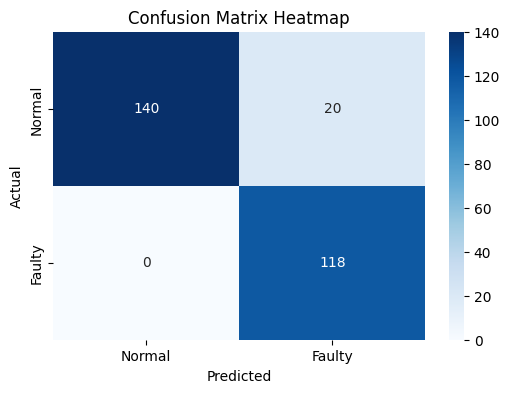

In [ ]:
# Train Evaluation
evaluate("/content/door_analysis_report_train_ground_truth.csv", "/content/door_analysis_report_train_rule.csv")


Accuracy: 0.9710144927536232

Confusion Matrix:
 [[38  2]
 [ 0 29]]

Classification Report:
               precision    recall  f1-score   support

      FAULTY       1.00      0.95      0.97        40
      NORMAL       0.94      1.00      0.97        29

    accuracy                           0.97        69
   macro avg       0.97      0.97      0.97        69
weighted avg       0.97      0.97      0.97        69



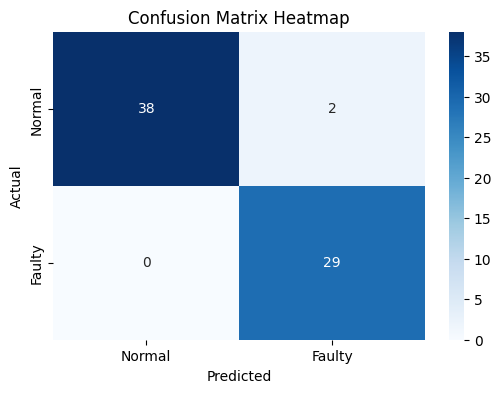

In [ ]:
# Test Evaluation
evaluate("/content/door_analysis_report_test_ground_truth.csv", "/content/door_analysis_report_test_rule.csv")

##  Approach Two (Machine Learning)
*We replaced the Status column above with the actual label manually !!*



In [ ]:
train_path = "/content/door_analysis_report_train_ground_truth.csv"
test_path = "/content/door_analysis_report_test_ground_truth.csv"

In [ ]:
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

In [ ]:
# Drop Output File & set Video as index
train_df = train_df.drop(columns=["Output File"]).set_index("Video")
test_df = test_df.drop(columns=["Output File"]).set_index("Video")

In [ ]:
train_df.head()

,Duration (s),Frames,Closed,Open,Semi,Cycles,Transitions,Avg Motion,Stuck Open,Stuck Semi,Lagging,Status
Video,,,,,,,,,,,,
lag-door_10.mp4,60.0,1499,530,655,314,2,12,0.4119,False,False,True,FAULTY
lag-door_100.mp4,75.8,1896,930,911,55,6,18,0.1350,False,False,True,FAULTY
lag-door_101.mp4,73.9,1848,124,839,885,1,19,0.1659,False,False,True,FAULTY
lag-door_102.mp4,75.9,1898,821,395,682,0,23,0.1868,False,False,True,FAULTY
lag-door_103.mp4,73.9,1847,1060,787,0,5,10,0.2776,False,False,True,FAULTY


In [ ]:
# Split target & features
X_train = train_df.drop(columns=["Status"])
y_train = train_df["Status"]
X_test = test_df.drop(columns=["Status"])
y_test = test_df["Status"]
categorical_columns = ["Stuck Open", "Stuck Semi", "Lagging"]
numeric_columns = [col for col in X_train.columns if col not in categorical_columns]

## Logistic Regression

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
         # Applay one hot encoding on categorical_columns
        ("cat", OneHotEncoder(drop="first"), categorical_columns),
         # Apply normalization on the numeric columns
        ("num", StandardScaler(), numeric_columns)
    ]
)
lr = LogisticRegression(
    random_state=42,
    max_iter=10,       # ensure convergence
    C=0.001,           # regularization strength
    solver="lbfgs",
    penalty="l2"
)

# Pipeline
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("clf", lr)
])

# Train
pipeline.fit(X_train, y_train)
# Predict on training data
y_train_pred = pipeline.predict(X_train)
train_acc = accuracy_score(y_train, y_train_pred)
print("Train Accuracy:", train_acc)

Train Accuracy: 0.9964028776978417


Test Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

      FAULTY       1.00      1.00      1.00        40
      NORMAL       1.00      1.00      1.00        29

    accuracy                           1.00        69
   macro avg       1.00      1.00      1.00        69
weighted avg       1.00      1.00      1.00        69


Confusion Matrix:
 [[40  0]
 [ 0 29]]


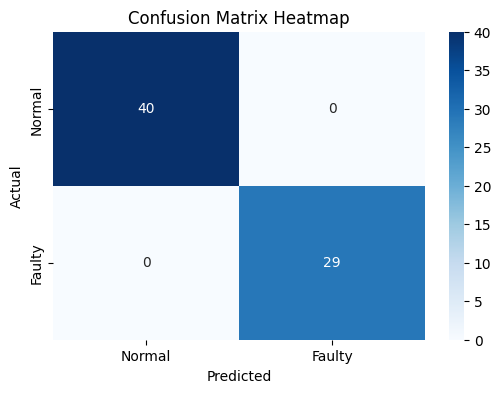

In [ ]:
# Predict
y_pred = pipeline.predict(X_test)

# Evaluate
cm = confusion_matrix(y_test, y_pred)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", cm)

# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=["Normal", "Faulty"],
    yticklabels=["Normal", "Faulty"])

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Heatmap")
plt.show()

## Support Vector Machine

In [ ]:
# SVM pipeline
svm = SVC(kernel="linear", C=0.001, random_state=42)

pipeline_svm = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("clf", svm)
])

pipeline_svm.fit(X_train, y_train)
# Predict on training data
y_train_pred = pipeline_svm.predict(X_train)
train_acc = accuracy_score(y_train, y_train_pred)
print("Train Accuracy:", train_acc)

Train Accuracy: 1.0


SVM Test Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

      FAULTY       1.00      1.00      1.00        40
      NORMAL       1.00      1.00      1.00        29

    accuracy                           1.00        69
   macro avg       1.00      1.00      1.00        69
weighted avg       1.00      1.00      1.00        69


Confusion Matrix:
 [[40  0]
 [ 0 29]]


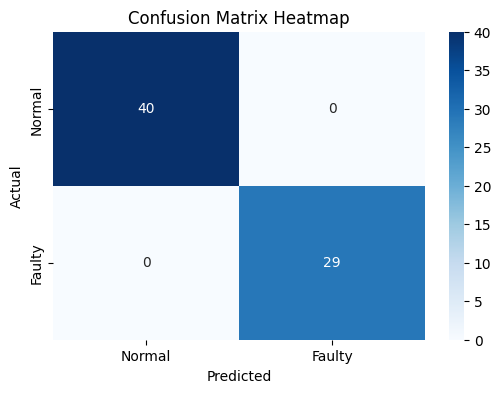

In [ ]:
# Predict on Testing data
y_pred_svm = pipeline_svm.predict(X_test)


cm = confusion_matrix(y_test, y_pred_svm)
print("SVM Test Accuracy:", accuracy_score(y_test, y_pred_svm))
print("\nClassification Report:\n", classification_report(y_test, y_pred_svm))
print("\nConfusion Matrix:\n", cm)
# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=["Normal", "Faulty"],
    yticklabels=["Normal", "Faulty"])

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Heatmap")
plt.show()


## K-Nearest Neighbors

In [ ]:
# KNN pipeline
knn = KNeighborsClassifier(
    n_neighbors=4,
    weights='uniform',
    metric='minkowski'
)

pipeline_knn = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("clf", knn)
])

# Train
pipeline_knn.fit(X_train, y_train)
# Predict on training data
y_train_pred = pipeline_knn.predict(X_train)
train_acc = accuracy_score(y_train, y_train_pred)
print("Train Accuracy:", train_acc)

Train Accuracy: 0.9964028776978417


KNN Test Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

      FAULTY       1.00      1.00      1.00        40
      NORMAL       1.00      1.00      1.00        29

    accuracy                           1.00        69
   macro avg       1.00      1.00      1.00        69
weighted avg       1.00      1.00      1.00        69


Confusion Matrix:
 [[40  0]
 [ 0 29]]


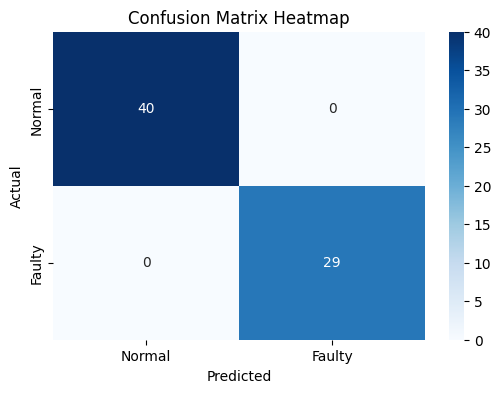

In [ ]:
# Predict
y_pred_knn = pipeline_knn.predict(X_test)

cm = confusion_matrix(y_test, y_pred_knn)
print("KNN Test Accuracy:", accuracy_score(y_test, y_pred_knn))
print("\nClassification Report:\n", classification_report(y_test, y_pred_knn))
print("\nConfusion Matrix:\n", cm)

# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=["Normal", "Faulty"],
    yticklabels=["Normal", "Faulty"])

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Heatmap")
plt.show()


In [ ]:
# Create ZIP of the entire output folder
zip_path = shutil.make_archive("door_analysis_results_test", "zip", "/workspace/OUTPUT_1")
# Show a clickable download link
FileLink(zip_path)